## Import Relevant Libraries 

In [2]:
!pip install darts yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 693.9/693.9 kB 37.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 90.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.0/150.0 kB 22.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 51.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.0/100.0 kB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.0/719.0 kB 34.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 33.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.4/46

In [3]:
from datetime import datetime
from datetime import timedelta
from dateutil.relativedelta import relativedelta

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.models import RNNModel
from darts.metrics import mape
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.models import forecasting
from darts.dataprocessing.transformers import Scaler, MissingValuesFiller


import yfinance as yf

## Data Pre-Processing 

In [4]:
#Getting date from one year ago
one_year_ago = datetime.now() - relativedelta(years=1) 
one_year_ago = one_year_ago.strftime("%Y-%m-%d")

#Getting date today
today = datetime.now()
today = today.strftime("%Y-%m-%d")

#Adding one day to the date one year ago 
one_year_ago_plus_one = datetime.now() - relativedelta(years=1) + timedelta(days=1)
one_year_ago_plus_one = one_year_ago_plus_one.strftime("%Y-%m-%d")
four_years_ago = datetime.now() - relativedelta(years=4)
four_years_ago = four_years_ago.strftime("%Y-%m-%d")
print(four_years_ago)
print(today)
#Accessing YFinance
ticker= yf.Ticker("fico")

#Getting pandas dataframe of stock data from one year ago
df = ticker.history(start=one_year_ago, end=today, interval="1d")
print(df)
idx = pd.date_range(start=one_year_ago_plus_one, end=today)
# print(idx)



#Making index into Datetime index
df.index = pd.DatetimeIndex(df.index)
df.index = df.index.tz_localize(None) 

#Reindexing dataframe to fill in missing dates due to stock market closing on weekends
df = df.reindex(idx, method = 'pad')


print(df)
print(len(df))



2019-05-10
2023-05-10
                                 Open        High         Low       Close  \
Date                                                                        
2022-05-10 00:00:00-04:00  347.730011  362.040009  345.440002  358.410004   
2022-05-11 00:00:00-04:00  353.450012  364.309998  349.170013  351.089996   
2022-05-12 00:00:00-04:00  347.239990  357.769989  346.660004  352.730011   
2022-05-13 00:00:00-04:00  356.640015  365.700012  352.809998  361.529999   
2022-05-16 00:00:00-04:00  359.429993  370.070007  357.600006  364.399994   
...                               ...         ...         ...         ...   
2023-05-03 00:00:00-04:00  740.469971  756.020020  732.099976  752.390015   
2023-05-04 00:00:00-04:00  748.669983  760.150024  736.000000  736.650024   
2023-05-05 00:00:00-04:00  739.919983  743.369995  730.330017  731.979980   
2023-05-08 00:00:00-04:00  729.539978  736.780029  729.539978  736.409973   
2023-05-09 00:00:00-04:00  735.419983  741.830017  733

In [5]:
#Put dataframe into a Darts "Timeseries" object so that data can be fed into a Darts forecasting model. For more information on Timeseries objects, please look here: https://unit8co.github.io/darts/generated_api/darts.timeseries.html 
series = TimeSeries.from_dataframe(df)

#Drop all columns besides "Close" Column
#adj_series = series.drop_columns(['Open', 'High', 'Low', 'Volume', 'Dividends', 'Stock Splits'])
adj_series = series.drop_columns(['Open','High','Low','Volume', 'Dividends', 'Stock Splits'])

Text(0.5, 1.0, 'Training and Validation Plots')

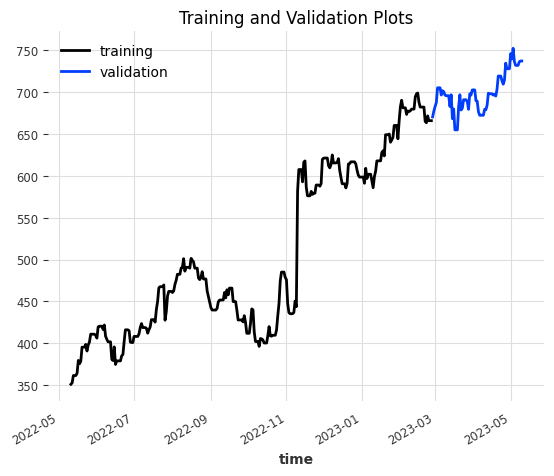

In [6]:

#Divide dataset into training and validation/testing sets. "Split_after" function is a method of a Darts Timeseries object. https://unit8co.github.io/darts/generated_api/darts.timeseries.html#darts.timeseries.TimeSeries.split_after
training, validation = adj_series.split_after(0.8)

#Plot training and testing data
training.plot(label='training')
validation.plot(label='validation')
plt.legend();
plt.title("Training and Validation Plots")

In [7]:
#Transform training set, validation set, and entire series to values between 0 and 1.
transformer = Scaler()
train_transformed = transformer.fit_transform(training)
val_transformed = transformer.transform(validation)
# series_transformed = transformer.transform(adj_series)
# print(train_transformed)
# print(val_transformed)
# print(series_transformed)

## Construct LSTM Model in Darts

In [8]:
#Define LSTM Model
my_model = RNNModel(
    model="LSTM",
    n_rnn_layers = 2, # Number of LSTM layers
    hidden_dim=9,
    dropout=0.13,
    batch_size=31,
    n_epochs=50,
    optimizer_kwargs={"lr": 1e-3}, #learning rate
    model_name="Stock_Forecast",
    log_tensorboard=False,
    training_length=30,
    input_chunk_length=14,
    force_reset=True,
    save_checkpoints=True,
    pl_trainer_kwargs={
      "accelerator": "gpu",
      "devices": [0]
    },
)

#Fit model on training data
my_model.fit(train_transformed)

#Predict values 
pred = my_model.predict(n=len(val_transformed))

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 1.2 K 
4 | V             | Linear           | 10    
---------------------------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:359: UserWarning: `ModelCheckpoint(monitor='val_loss')` could not find the monitored key in the returned metrics: ['train_loss', 'epoch', 'step']. HINT: Did you call `log('val_loss', value)` in the `LightningModule`?
  warning_cache.warn(m)
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

## Evaluating Results

MAPE = 7.18%


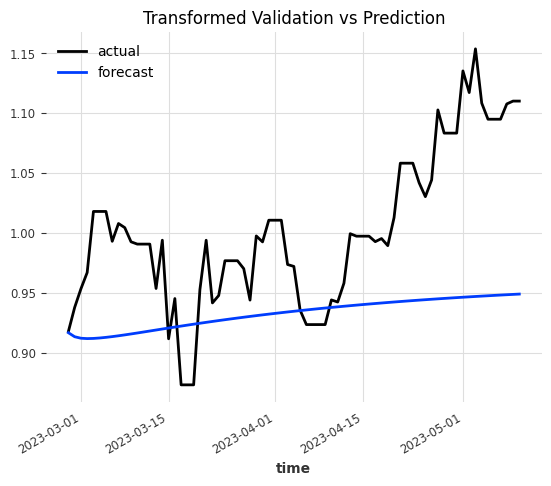

In [9]:
#Plot transformed validation set vs prediction 
val_transformed.plot(label='actual')
pred.plot(label='forecast')
plt.legend();
plt.title("Transformed Validation vs Prediction")
print('MAPE = {:.2f}%'.format(mape(val_transformed, pred)))


MAPE = 3.64%


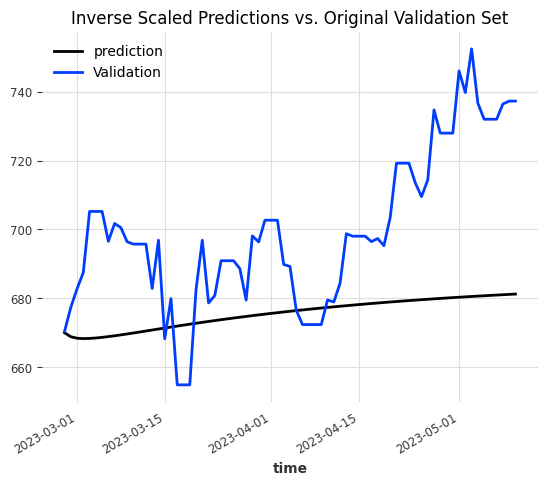

In [10]:
#Perform inverse scaling on prediction
inverse_scaler_pred = transformer.inverse_transform(pred)

#Plot inverse scaled predictions with validation  
inverse_scaler_pred.plot(label='prediction')
validation.plot(label='Validation')
plt.legend();
plt.title("Inverse Scaled Predictions vs. Original Validation Set")
print('MAPE = {:.2f}%'.format(mape(validation, inverse_scaler_pred)))

MAPE = 3.64%


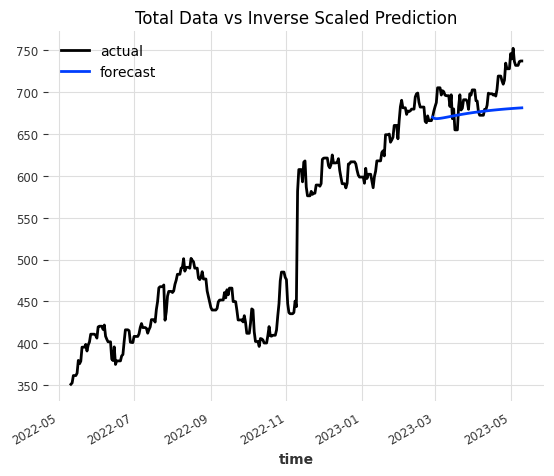

In [11]:
#Plot total data vs prediction
adj_series.plot(label='actual')
inverse_scaler_pred.plot(label='forecast')
plt.legend();
plt.title("Total Data vs Inverse Scaled Prediction")
print('MAPE = {:.2f}%'.format(mape(adj_series, inverse_scaler_pred)))

In [20]:
# import optuna
# from sklearn.model_selection import cross_val_score


# def objective(trial):

#     n_rnn_layers = trial.suggest_int("n_rnn_layers", 1, 5)
#     hidden_dim = trial.suggest_int("hidden_dim", 1, 5)
#     input_chunk_length = trial.suggest_int("input_chunk_length", 1,5)

#     my_model = RNNModel(
#     model="LSTM",
#     n_rnn_layers = n_rnn_layers,
#     hidden_dim= hidden_dim,
#     input_chunk_length=input_chunk_length
#     )

#     my_model.fit(training)

#     preds = my_model.predict(series=training, n=len(validation))
#     mapes = mape(validation, preds, n_jobs=-1, verbose=True)
#     smape_val = np.mean(mapes)

#     return smape_val if smape_val != np.nan else float("inf")


# def print_callback(study, trial):
#     print(f"Current value: {trial.value}, Current params: {trial.params}")
#     print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

# study = optuna.create_study(direction="minimize")
# study.optimize(objective, n_trials=5, callbacks=[print_callback])




In [21]:
# !pip install yfinance
# !pip install darts

# import torch
# import torch.nn as nn
# import torch.optim as optim
# import numpy as np
# import pandas as pd
# #import shutil
# from sklearn.preprocessing import MinMaxScaler
# #from tqdm import tqdm_notebook as tqdm
# import matplotlib.pyplot as plt

# from darts import TimeSeries
# from darts.models import RNNModel, ExponentialSmoothing, BlockRNNModel
# from darts.metrics import mape, mse
# #from darts.utils.statistics import check_seasonality, plot_acf
# #from darts.datasets import AirPassengersDataset, SunspotsDataset
# from darts.utils.timeseries_generation import datetime_attribute_timeseries
# from darts.models import forecasting
# from darts.dataprocessing.transformers import Scaler, MissingValuesFiller

# import yfinance as yf
# tickers = ['AAPL', 'ACN', 'ADBE', 'ADI', 'ADSK', 'AKAM', 'AMAT', 'AMD', 'ANET', 'ANSS']
# for tk in tickers:
#     ticker= yf.Ticker(tk)
#     df = ticker.history(start="2022-04-01", end="2023-04-01", interval="1d")

#     # data.reset_index(inplace=True)
#     # data = data[['Date', 'Close']]

#     idx = pd.date_range(start='2022-04-01', end='2023-04-01')
#     df.index = pd.DatetimeIndex(df.index)
#     df.index = df.index.tz_localize(None) 
#     # # #df['Date'] = pd.to_datetime(df['Date'])
#     # # #print(df)
#     # # #df.set_index='Date'
#     # # #print(df)
#     # # df.index = pd.DatetimeIndex(df.index)
#     # # print(df)
#     df = df.reindex(idx, method = 'pad')
#     print(df)
#     series = TimeSeries.from_dataframe(df)
#     print(series)

#     adj_series = series.drop_columns(['Open', 'High', 'Low', 'Volume', 'Dividends', 'Stock Splits'])
#     training, validation = adj_series.split_after(0.8)
#     training.plot(label='training')
#     validation.plot(label='validation')
#     plt.legend();
#     from darts.dataprocessing.transformers import Scaler
#     transformer = Scaler()
#     train_transformed = transformer.fit_transform(training)
#     val_transformed = transformer.transform(validation)
#     series_transformed = transformer.transform(adj_series)
#     print(train_transformed)
#     print(val_transformed)
#     print(series_transformed)
#     # scaler_stock = Scaler()
#     # series_stock_scaled = scaler_stock.fit_transform(adj_series)
#     # print(series_stock_scaled)
#     # training, validation = adj_series.split_after(0.8)
#     my_model = RNNModel(
#         model="LSTM",
#         n_rnn_layers = 3,
#         hidden_dim=4,
#         dropout=0,
#         batch_size=16,
#         n_epochs=10,
#         optimizer_kwargs={"lr": 1e-3},
#         model_name="Air_RNN",
#         log_tensorboard=True,
#         random_state=42,
#         training_length=20,
#         input_chunk_length=3,
#         force_reset=True,
#         save_checkpoints=True,
#     )
#     my_model.fit(train_transformed)
#     pred = my_model.predict(n=len(val_transformed))
#     val_transformed.plot(label='actual')
#     pred.plot(label='forecast')
#     plt.legend();
#     print('MAPE = {:.2f}%'.format(mape(val_transformed, pred)))
#     series_transformed.plot(label='actual')
#     pred.plot(label='forecast')
#     plt.legend();
#     print('MAPE = {:.2f}%'.format(mape(series_transformed, pred)))
#     inverse_scaler_pred = transformer.inverse_transform(pred)

#     inverse_scaler_pred.plot(label='prediction')
#     validation.plot(label='Validation')
#     plt.legend();

#     !pip install optuna
#     import optuna
#     from sklearn.model_selection import cross_val_score


#     def objective(trial):

#         n_rnn_layers = trial.suggest_int("n_rnn_layers", 1, 5)
#         hidden_dim = trial.suggest_int("hidden_dim", 1, 5)
#         input_chunk_length = trial.suggest_int("input_chunk_length", 1,5)

#         my_model = RNNModel(
#         model="LSTM",
#         n_rnn_layers = n_rnn_layers,
#         hidden_dim= hidden_dim,
#         input_chunk_length=input_chunk_length
#         )

#         my_model.fit(training)

#         preds = my_model.predict(series=training, n=len(validation))
#         mapes = mape(validation, preds, n_jobs=-1, verbose=True)
#         smape_val = np.mean(mapes)

#         return smape_val if smape_val != np.nan else float("inf")


#     def print_callback(study, trial):
#         print(f"Current value: {trial.value}, Current params: {trial.params}")
#         print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

#     study = optuna.create_study(direction="minimize")
#     study.optimize(objective, n_trials=5, callbacks=[print_callback])




In [22]:
# #Optuna Hyperparameter Optimization

# import numpy as np
# import optuna
# import torch
# from optuna.integration import PyTorchLightningPruningCallback
# from pytorch_lightning.callbacks import EarlyStopping
# from sklearn.preprocessing import MaxAbsScaler

# from darts.dataprocessing.transformers import Scale
# from darts import TimeSeries
# from darts.datasets import AirPassengersDatasetr
# from darts.metrics import smape, mape
# from darts.models import RNNModel
# from darts.utils.likelihood_models import GaussianLikelihood
# from darts.utils.timeseries_generation import datetime_attribute_timeseries
# from darts.models import forecasting
# from darts.dataprocessing.transformers import Scaler, MissingValuesFiller

# from datetime import datetime
# from datetime import timedelta
# from dateutil.relativedelta import relativedelta

# import torch
# import torch.nn as nn
# import torch.optim as optim
# import pandas as pd
# from sklearn.preprocessing import MinMaxScaler
# import matplotlib.pyplot as plt

# from darts.utils.timeseries_generation import datetime_attribute_timeseries
# from darts.models import forecasting
# from darts.dataprocessing.transformers import Scaler, MissingValuesFiller


# import yfinance as yf
# # load data
# series = AirPassengersDataset().load().astype(np.float32)

# # split in train / validation (note: in practice we would also need a test set)
# VAL_LEN = 36
# train, val = series[:-VAL_LEN], series[-VAL_LEN:]

# # scale
# scaler = Scaler(MaxAbsScaler())
# train = scaler.fit_transform(train)
# val = scaler.transform(val)

# # define objective function
# def objective(trial):
#     # select input and output chunk lengths
#     in_len = trial.suggest_int("in_len", 12, 36)
#     out_len = trial.suggest_int("out_len", 1, in_len-1)

#     # Other hyperparameters
#     kernel_size = trial.suggest_int("kernel_size", 2, 5)
#     num_filters = trial.suggest_int("num_filters", 1, 5)
#     weight_norm = trial.suggest_categorical("weight_norm", [False, True])
#     dilation_base = trial.suggest_int("dilation_base", 2, 4)
#     dropout = trial.suggest_float("dropout", 0.0, 0.4)
#     lr = trial.suggest_float("lr", 5e-5, 1e-3, log=True)
#     include_year = trial.suggest_categorical("year", [False, True])

#     # throughout training we'll monitor the validation loss for both pruning and early stopping
#     pruner = PyTorchLightningPruningCallback(trial, monitor="val_loss")
#     early_stopper = EarlyStopping("val_loss", min_delta=0.001, patience=3, verbose=True)
#     callbacks = [pruner, early_stopper]

#     # detect if a GPU is available
#     if torch.cuda.is_available():
#         pl_trainer_kwargs = {
#             "accelerator": "gpu",
#             "gpus": -1,
#             "auto_select_gpus": True,
#             "callbacks": callbacks,
#         }
#         num_workers = 4
#     else:
#         pl_trainer_kwargs = {"callbacks": callbacks}
#         num_workers = 0

#     # optionally also add the (scaled) year value as a past covariate
#     if include_year:
#         encoders = {"datetime_attribute": {"past": ["year"]},
#                     "transformer": Scaler()}
#     else:
#         encoders = None

#     # reproducibility
#     torch.manual_seed(42)

#     # build the TCN model
#     model = TCNModel(
#         input_chunk_length=in_len,
#         output_chunk_length=out_len,
#         batch_size=32,
#         n_epochs=100,
#         nr_epochs_val_period=1,
#         kernel_size=kernel_size,
#         num_filters=num_filters,
#         weight_norm=weight_norm,
#         dilation_base=dilation_base,
#         dropout=dropout,
#         optimizer_kwargs={"lr": lr},
#         add_encoders=encoders,
#         likelihood=GaussianLikelihood(),
#         pl_trainer_kwargs=pl_trainer_kwargs,
#         model_name="tcn_model",
#         force_reset=True,
#         save_checkpoints=True,
#     )


#     # when validating during training, we can use a slightly longer validation
#     # set which also contains the first input_chunk_length time steps
#     model_val_set = scaler.transform(series[-(VAL_LEN + in_len) :])

#     # train the model
#     model.fit(
#         series=train,
#         val_series=model_val_set,
#         num_loader_workers=num_workers,
#     )

#     # reload best model over course of training
#     model = TCNModel.load_from_checkpoint("tcn_model")

#     # Evaluate how good it is on the validation set, using sMAPE
#     preds = model.predict(series=train, n=val_len)
#     smapes = smape(val, preds, n_jobs=-1, verbose=True)
#     smape_val = np.mean(smapes)

#     return smape_val if smape_val != np.nan else float("inf")


# # for convenience, print some optimization trials information
# def print_callback(study, trial):
#     print(f"Current value: {trial.value}, Current params: {trial.params}")
#     print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")


# # optimize hyperparameters by minimizing the sMAPE on the validation set
# study = optuna.create_study(direction="minimize")
# study.optimize(objective, n_trials=100, callbacks=[print_callback])